$$\newcommand{\braket}[3]{\left\langle{#1}\middle|{#2}|{#3}\right\rangle}$$

$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$

## Example Notebook for Gauge invariance

This Notebook is based on the following [paper](https://science.sciencemag.org/content/367/6482/1128) of Markus Oberthaler. In this paper a new scalable analog quantum simulator of a U(1) gauge theory is proposed. By using interspecies spin-changing collisions between particles, a gauge-invariant interaction between matter and gauge-field is achieved. In this case an atomic mixture of sodium and lithium is used.

In [1]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt

import strawberryfields as sf
from strawberryfields import ops

%config InlineBackend.figure_format='retina'

The full quantum gate for the experiment:

<img width="200" height="300" src="Gates/Lattice_Gates.svg">

At first we want to model figure 2 in the paper. This essentially just flips the spin of the $Na$ atoms. Either a qubit simulator or a the strawberryfields boson simulator can be used. At first we want to take a look at the qubit simulator. We will later see that the strawebrryfields simulator suits the experiment better. 

In the case of the qubit simulator we have a one wire circuit. The wire represents the collective spin of the Sodium Atoms. First the collective spin is initiated to $-1$. Then a rotation around the x-axis is performed and then the expectation value of the qubit is measured. If we want to recreate figure 2 in the paper we can initate an additional wire which represents the lithium atoms $\frac{N_p}{N}$ ... . No gate operation is performed on this wire. 

In [2]:
dev_qubit = qml.device('default.qubit', wires=2)

@qml.qnode(dev_qubit)
def Simple_Na_flip_qubit(phi):
    """
    Qubit circuit for Chi operator
    """
    #Initiate State -1 of Lz/L
    qml.RX(np.pi, wires=0)
    #Initiate State 0 of Np/N
    qml.RX(np.pi/2, wires=1)
    #Rotate Lz
    qml.RX(phi, wires=0)
    return [qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliZ(1))]


In [3]:
Simple_Na_flip_qubit(np.pi/2)
print(Simple_Na_flip_qubit.draw())

 0: ──RX(3.142)──RX(1.571)──┤ ⟨Z⟩ 
 1: ──RX(1.571)─────────────┤ ⟨Z⟩ 



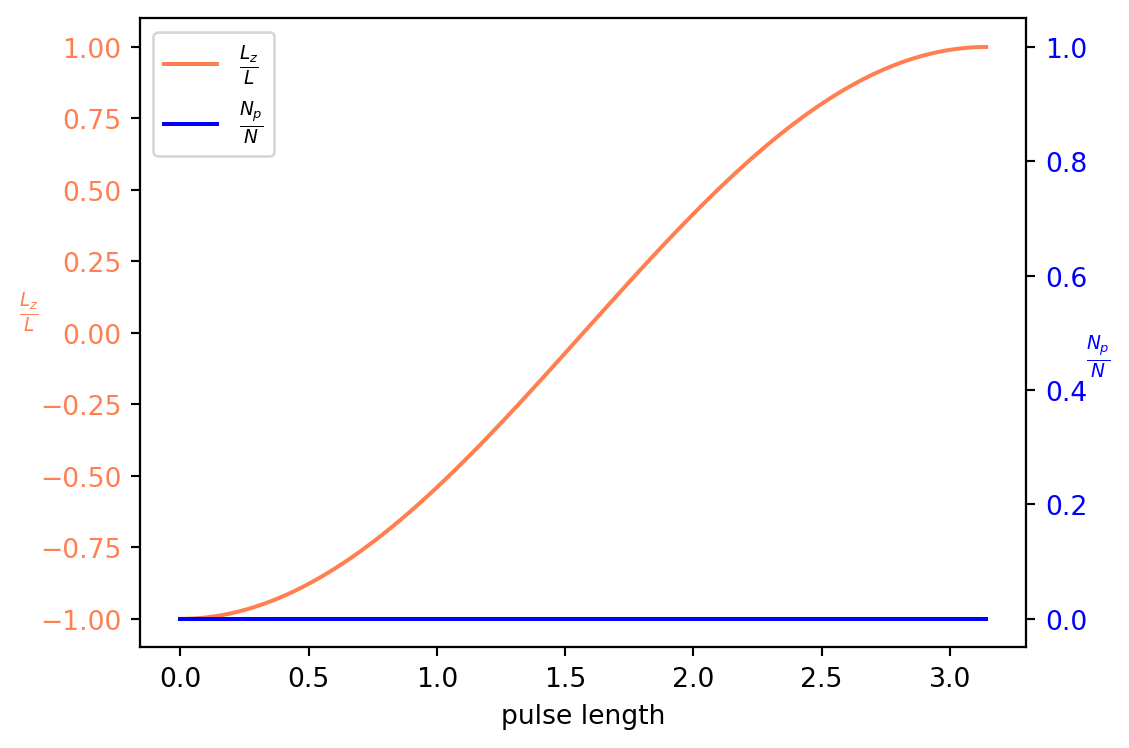

In [4]:


phis = np.linspace(0, np.pi, 100)
res = np.array([Simple_Na_flip_qubit(phi) for phi in phis])

fig, ax1 = plt.subplots(dpi=96)

ax1.set_xlabel(r'pulse length')
ax1.set_ylabel(r"$\frac{L_z}{L}$", color="coral", rotation=0)
leg1 = ax1.plot(phis, res[:, 0], color="coral",  label=r"$\frac{L_z}{L}$")
ax1.tick_params(axis='y', labelcolor="coral")
plt.legend()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel(r"$\frac{N_p}{N}$", color="blue", rotation=0) 
leg2 = ax2.plot(phis, res[:, 1], color="blue", label=r"$\frac{N_p}{N}$")
ax2.set_ylim(-0.05, 1.05)
ax2.tick_params(axis='y', labelcolor="blue")
#ax2.set_ylim(-0.01, 1)
fig.tight_layout()  # otherwise the right y-label is slightly clipped

# added these three lines
lns = leg1+leg2
labs = [l.get_label() for l in lns]
_ = ax1.legend(lns, labs, loc=0)

In the qubit circuit all sodium atoms are represented by one qubit state. We can also use the strawberryfileds simulator to create 2 wires where each where wire one represents sodium atoms in the $|\downarrow\rangle$ state and wire two sodium atoms in the $|\uparrow\rangle$ state

In [5]:
#For computation purposes we will use 2 different devices
dev_sodium = qml.device('strawberryfields.fock', wires=2, cutoff_dim=30)
dev_lithium = qml.device('strawberryfields.fock', wires=2, cutoff_dim=2)

@qml.qnode(dev_sodium)
def gauge_Lz(x, theta, var=False):
    """
    Lz Spin flip gate
    """
    qml.Displacement(x, 0, wires=0)
    qml.Beamsplitter(theta, 0, wires=[0, 1])
    if var:  
        return [qml.var(qml.NumberOperator(0)),qml.var(qml.NumberOperator(1))]
    else:
        return [qml.expval(qml.NumberOperator(0)),qml.expval(qml.NumberOperator(1))]
    
@qml.qnode(dev_lithium)
def gauge_Np(var=False):
    """
    Np gate
    """
    qml.Displacement(0, 0, wires=0)
    
    if var:  
        return [qml.var(qml.NumberOperator(0)),qml.var(qml.NumberOperator(1))]
    else:
        return [qml.expval(qml.NumberOperator(0)),qml.expval(qml.NumberOperator(1))]

In [6]:
gauge_Lz(np.sqrt(20), np.pi/4)
print(gauge_Lz.draw())
gauge_Np()
print(gauge_Np.draw())

 0: ──D(4.472, 0)──╭BS(0.785, 0)──┤ ⟨n⟩ 
 1: ───────────────╰BS(0.785, 0)──┤ ⟨n⟩ 

 0: ──D(0, 0)──┤ ⟨n⟩ 
 1: ───────────┤ ⟨n⟩ 



In [7]:
simulated_atoms = 20
thetas = np.linspace(0, np.pi/2, 20)


res_Lz = np.array([gauge_Lz(np.sqrt(simulated_atoms), theta) for theta in thetas])
res_Np = np.array([gauge_Np() for theta in thetas])

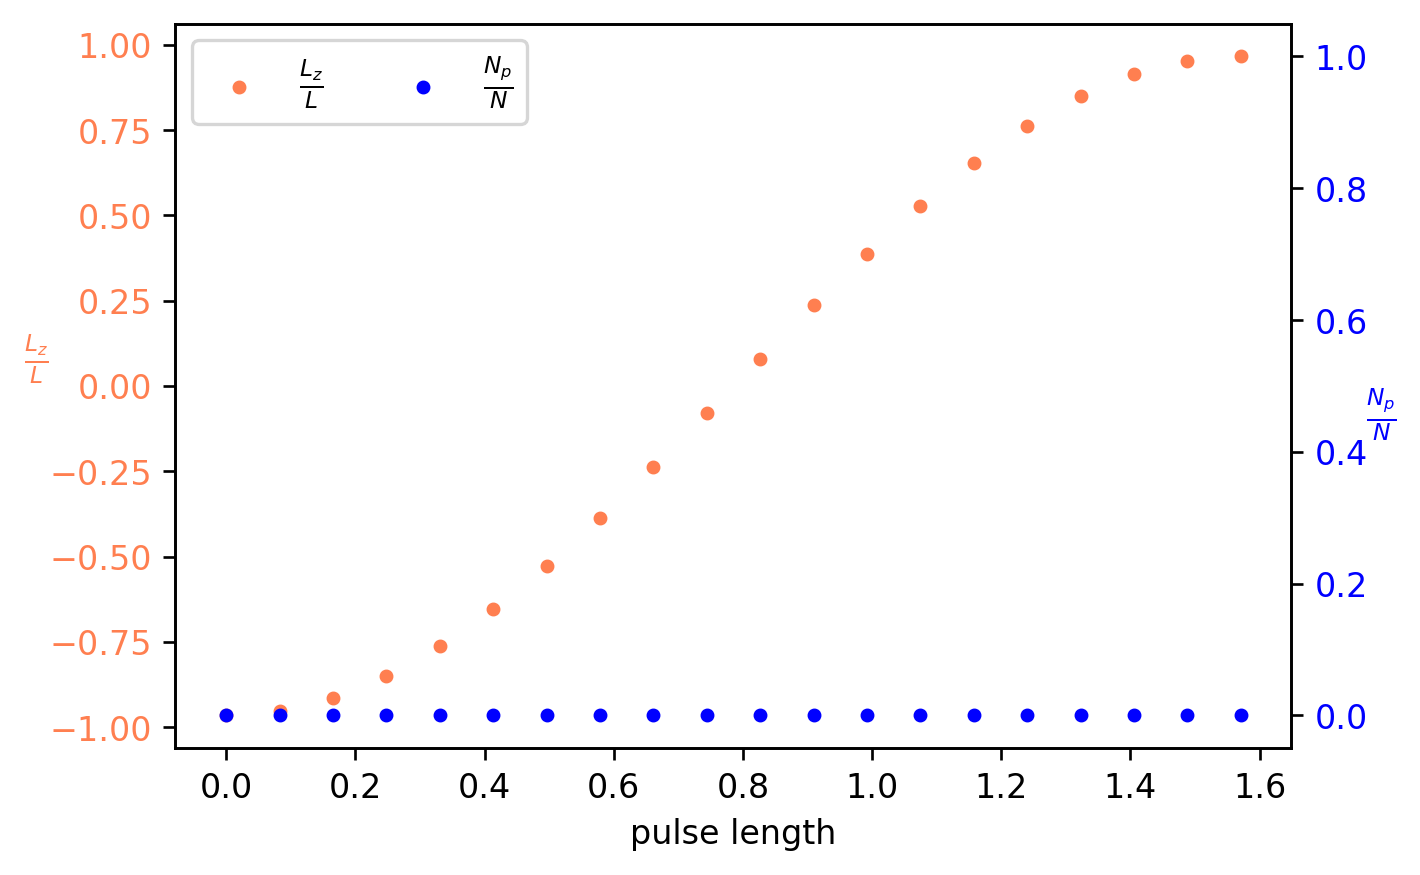

In [8]:
err = np.array([gauge_Lz(np.sqrt(simulated_atoms), theta, var=True) for theta in thetas])

fig, ax1 = plt.subplots(dpi=120)

ax1.set_xlabel(r'pulse length')
ax1.set_ylabel(r"$\frac{L_z}{L}$", color="coral", rotation=0)
leg1 = ax1.scatter(thetas, (-res_Lz[:, 0]+res_Lz[:, 1])/simulated_atoms, color="coral", s=10)
ax1.tick_params(axis='y', labelcolor="coral")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel(r"$\frac{N_p}{N}$", color="blue", rotation=0)
leg2 = ax2.scatter(thetas, res_Np[:, 1], color="blue", s=10) 
ax2.set_ylim(-0.05, 1.05)
ax2.tick_params(axis='y', labelcolor="blue")




_ = plt.legend((leg1, leg2),(r"$\frac{L_z}{L}$", r"$\frac{N_p}{N}$"), loc="upper left", scatterpoints=1, ncol=3)

We now want to take a closer look at the $\lambda$-gate.

In [9]:
dev_lambda = qml.device('strawberryfields.fock', wires=4, cutoff_dim=10)

@qml.qnode(dev_lambda)
def lambda_gate(sod_up, sod_down, lit_v, lit_p, theta, var=False):
    """
    Lz Spin flip gate
    """
    
    qml.Displacement(sod_up, 0, wires=0)
    qml.Displacement(sod_down, 0, wires=1)
    qml.Displacement(lit_v, 0, wires=2)
    qml.Displacement(lit_p, 0, wires=3)
    qml.Beamsplitter(theta, 0, wires=[0, 1])
    qml.Beamsplitter(theta, 0, wires=[2, 3])
    if var:  
        return [qml.var(qml.NumberOperator(0)),qml.var(qml.NumberOperator(1)), 
                qml.var(qml.NumberOperator(2)),qml.var(qml.NumberOperator(3))]
    else:
        return [qml.expval(qml.NumberOperator(0)),qml.expval(qml.NumberOperator(1)), 
                qml.expval(qml.NumberOperator(2)),qml.expval(qml.NumberOperator(3))]

In [10]:
r = lambda_gate(np.sqrt(2), 0, np.sqrt(2), 0, 0)

/Users/noahwach/venvs/HiWi/lib/python3.7/site-packages/strawberryfields/program.py:553: UserWarning: The circuit consists of 2 disconnected components.


In [16]:
thetas = np.linspace(0, np.pi/2, 10)
atoms = 4
res_lambda = np.array([lambda_gate(np.sqrt(atoms), 0, np.sqrt(atoms), 0, theta) for theta in thetas])

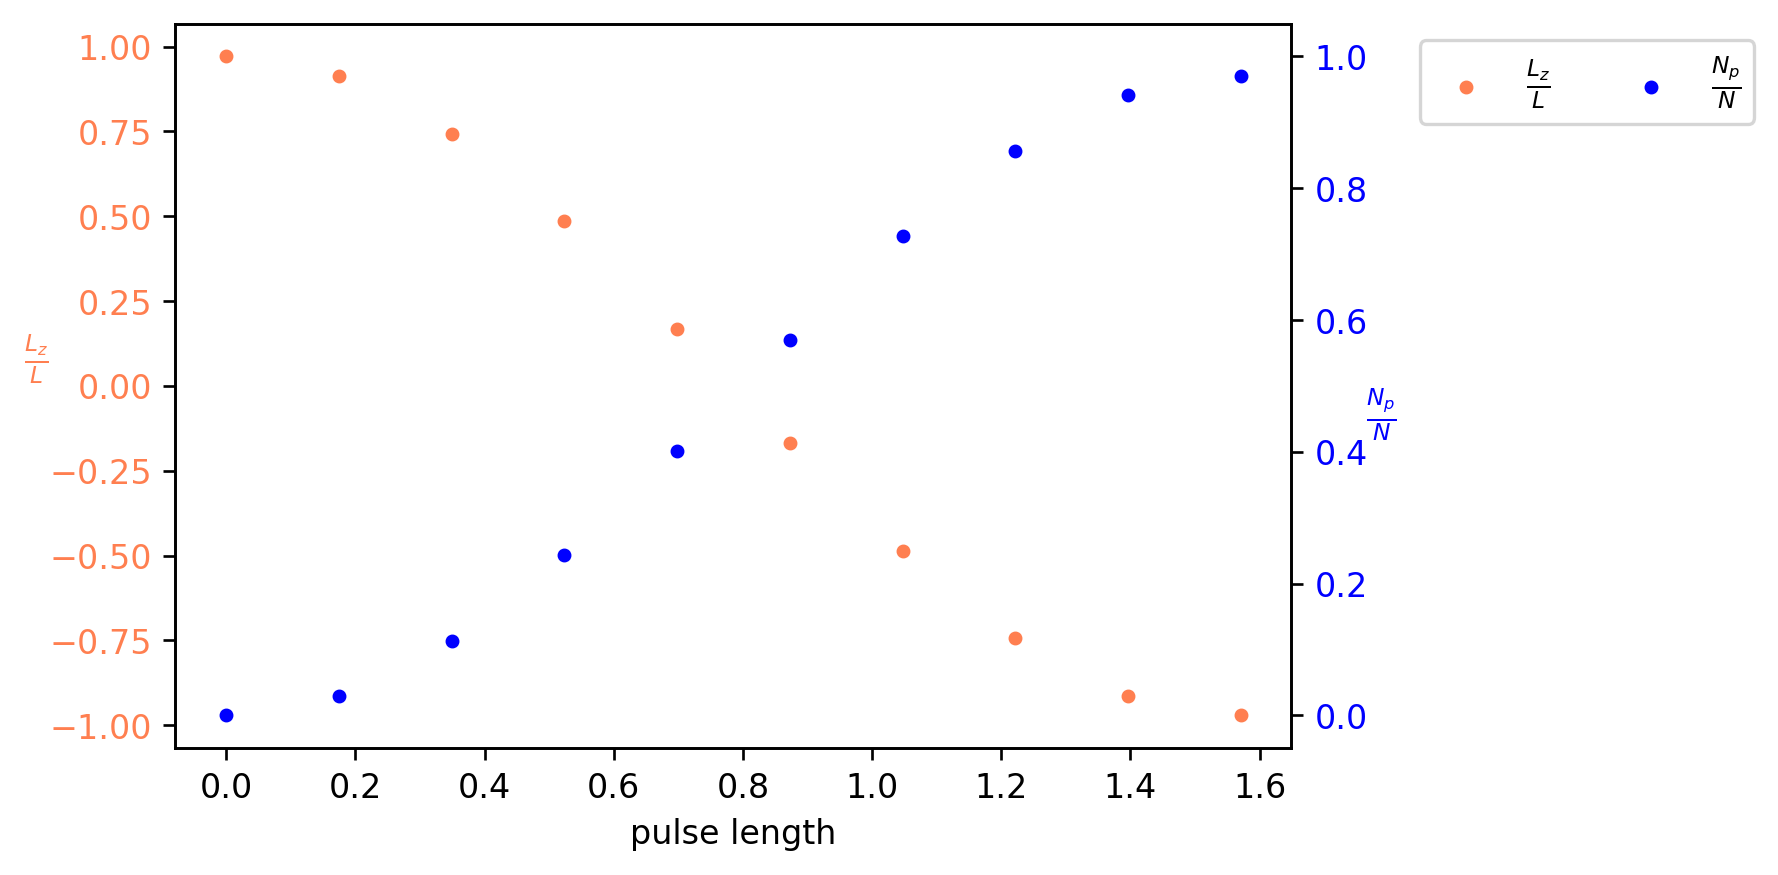

In [17]:
fig, ax1 = plt.subplots(dpi=120)

ax1.set_xlabel(r'pulse length')
ax1.set_ylabel(r"$\frac{L_z}{L}$", color="coral", rotation=0)
leg1 = ax1.scatter(thetas, (res_lambda[:, 0]-res_lambda[:, 1])/atoms, color="coral", s=10)
ax1.tick_params(axis='y', labelcolor="coral")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel(r"$\frac{N_p}{N}$", color="blue", rotation=0)
leg2 = ax2.scatter(thetas, res_lambda[:, 3]/atoms, color="blue", s=10) 
ax2.set_ylim(-0.05, 1.05)
ax2.tick_params(axis='y', labelcolor="blue")


_ = plt.legend((leg1, leg2),(r"$\frac{L_z}{L}$", r"$\frac{N_p}{N}$"), 
               loc="upper left", scatterpoints=1, ncol=3, bbox_to_anchor=(1.1, 1))

In [18]:
def circuit(theta):
    prog = sf.Program(4)
    with prog.context as q:
        ops.Fock(2) | q[0]
        ops.Fock(0) | q[1]
        ops.Fock(2) | q[2]
        ops.Fock(0) | q[3]
        ops.BSgate(theta, 0) | (q[0], q[1])
        ops.BSgate(theta, 0) | (q[2], q[3])
        ops.MeasureFock()| q
    eng = sf.Engine("fock", backend_options={"cutoff_dim" :  6})
    result = eng.run(prog)
    return result

In [20]:
def measure_shots_theta(shots, thetas, number_wires, circ):
    res = np.zeros((len(thetas), shots, number_wires))
    for n, theta in enumerate(thetas):
        print(f"Calculating theta={theta:.2f}", end='\r')
        for i in range(shots):
            result = circ(theta)
            for j in range(number_wires):
                res[n, i, j] = result.samples[0, j]
    return res

In [21]:


theta_samples = 6
shots = 5
res = np.zeros((theta_samples, shots, 4))
thetas = np.linspace(0, np.pi/2, theta_samples)

res = measure_shots_theta(10, thetas, 4, circuit)
print("")
print(res)

print("""
Mean value of each value of theta
""", res.mean(axis=1))

Calculating theta=1.57
[[[2. 0. 2. 0.]
  [2. 0. 2. 0.]
  [2. 0. 2. 0.]
  [2. 0. 2. 0.]
  [2. 0. 2. 0.]
  [2. 0. 2. 0.]
  [2. 0. 2. 0.]
  [2. 0. 2. 0.]
  [2. 0. 2. 0.]
  [2. 0. 2. 0.]]

 [[2. 0. 2. 0.]
  [1. 1. 2. 0.]
  [2. 0. 2. 0.]
  [1. 1. 2. 0.]
  [2. 0. 2. 0.]
  [2. 0. 2. 0.]
  [2. 0. 0. 2.]
  [2. 0. 2. 0.]
  [2. 0. 2. 0.]
  [2. 0. 2. 0.]]

 [[2. 0. 1. 1.]
  [0. 2. 1. 1.]
  [1. 1. 2. 0.]
  [1. 1. 2. 0.]
  [2. 0. 1. 1.]
  [1. 1. 1. 1.]
  [2. 0. 1. 1.]
  [1. 1. 2. 0.]
  [1. 1. 0. 2.]
  [1. 1. 1. 1.]]

 [[1. 1. 0. 2.]
  [0. 2. 0. 2.]
  [1. 1. 0. 2.]
  [0. 2. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [0. 2. 0. 2.]
  [0. 2. 1. 1.]
  [0. 2. 2. 0.]
  [0. 2. 1. 1.]]

 [[1. 1. 0. 2.]
  [0. 2. 0. 2.]
  [0. 2. 1. 1.]
  [0. 2. 0. 2.]
  [0. 2. 0. 2.]
  [0. 2. 0. 2.]
  [0. 2. 0. 2.]
  [1. 1. 0. 2.]
  [0. 2. 0. 2.]
  [1. 1. 0. 2.]]

 [[0. 2. 0. 2.]
  [0. 2. 0. 2.]
  [0. 2. 0. 2.]
  [0. 2. 0. 2.]
  [0. 2. 0. 2.]
  [0. 2. 0. 2.]
  [0. 2. 0. 2.]
  [0. 2. 0. 2.]
  [0. 2. 0. 2.]
  [0. 2. 0. 2.]]]

Mean

In [22]:
theta_samples = 5
shots = 20
res = np.zeros((theta_samples, shots, 4))
thetas = np.linspace(0, np.pi/2, theta_samples)

for n, theta in enumerate(thetas):
    print(f"Calculating theta={theta:.2f}", end='\r')
    for i in range(shots):
        result = circuit(theta)
        
        res[n, i, 0] = result.samples[0, 0]
        res[n, i, 1] = result.samples[0, 1]
        res[n, i, 2] = result.samples[0, 2]
        res[n, i, 3] = result.samples[0, 3]
print("")

res.mean(axis=1)

Calculating theta=1.57


array([[2.  , 0.  , 2.  , 0.  ],
       [1.6 , 0.4 , 1.85, 0.15],
       [1.25, 0.75, 1.1 , 0.9 ],
       [0.2 , 1.8 , 0.15, 1.85],
       [0.  , 2.  , 0.  , 2.  ]])

In [23]:
def circuit(theta):
    prog = sf.Program(2)
    with prog.context as q:
        ops.Fock(0)  | q[0]
        ops.Fock(1)  | q[1]
        #ops.Fock(2)  | q[2]
        #ops.BSgate(theta)|(q[0], q[1])
        ops.CXgate(1)    | (q[0], q[1])
        ops.MeasureFock()| q
    eng = sf.Engine("fock", backend_options={"cutoff_dim" :  3})
    result = eng.run(prog)
    return result

In [24]:
thetas = np.linspace(0, np.pi, 10)
res = measure_shots_theta(100, thetas, 2, circuit)

In [25]:
print(res)

[[[1. 0.]
  [0. 1.]
  [0. 1.]
  ...
  [0. 1.]
  [0. 1.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]
  [0. 1.]
  ...
  [1. 0.]
  [0. 1.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]
  [0. 1.]
  ...
  [0. 1.]
  [1. 0.]
  [0. 1.]]

 ...

 [[0. 1.]
  [1. 0.]
  [0. 1.]
  ...
  [0. 1.]
  [0. 1.]
  [0. 1.]]

 [[0. 1.]
  [0. 1.]
  [0. 1.]
  ...
  [2. 1.]
  [0. 1.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]
  [1. 0.]
  ...
  [0. 1.]
  [0. 1.]
  [0. 1.]]]


In [26]:
print(res.mean(axis=1))

[[0.4  0.72]
 [0.28 0.82]
 [0.25 0.77]
 [0.26 0.78]
 [0.29 0.79]
 [0.32 0.82]
 [0.24 0.82]
 [0.22 0.86]
 [0.32 0.78]
 [0.26 0.8 ]]


In [27]:
print(np.mean(res, axis=1))

[[0.4  0.72]
 [0.28 0.82]
 [0.25 0.77]
 [0.26 0.78]
 [0.29 0.79]
 [0.32 0.82]
 [0.24 0.82]
 [0.22 0.86]
 [0.32 0.78]
 [0.26 0.8 ]]


In [28]:
np.sum(res, axis=1)

array([[40., 72.],
       [28., 82.],
       [25., 77.],
       [26., 78.],
       [29., 79.],
       [32., 82.],
       [24., 82.],
       [22., 86.],
       [32., 78.],
       [26., 80.]])